# Create a Land-Ocean mask

For training purposes, I would like to have a label for each cell in the gird that tells me whether I should use it in training or not.

# Final solution:

To create a landmask of any grid, first load regionmask land features and the lat,lon datasets that you want to mask.

Then create the mask as follows:

In [3]:
import regionmask
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.append("../")
from src.processing import select_datavars, select_dims, transform_dataset

save_path = None # "../data/processed/winsat_landmask.nc"


In [4]:
# Load some data: Windsat as example
data_path = "../data/raw/daily_Windsat/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_17.nc"
ds = xr.open_dataset(data_path, decode_times=False)

# Preprocess the data: roll longitude to have 180 to -180 degrees
ds = select_dims(ds)
ds = transform_dataset(ds)
ds = select_datavars(ds)

# Find the variables / corrdinates and extract the values
lat = ds.lat.values
lon = ds.lon.values

# Load the regionmask object
land = regionmask.defined_regions.natural_earth_v5_1_2.land_10

# Create the mask as an xarray.Datarray
mask = land.mask(lon, lat)

# Save it for later:
if save_path:
    mask.to_netcdf(save_path)
    mask

### Assign the values to the array you are working with 
Since dimensions will be named diferently, make sure to tell xarray which names the grid dimnesions have in the original dataset

In [5]:
ds["mask"] = (("latitude_grid","longitude_grid"), mask.values)
ds

<xarray.Dataset> Size: 116MB
Dimensions:         (longitude_grid: 1440, latitude_grid: 720, swath_sector: 2,
                     frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB -89.88 -89.62 ... 89.62 89.88
    lon             (longitude_grid) float32 6kB 180.1 180.4 ... 179.6 179.9
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables:
    longitude       (longitude_grid) float32 6kB 180.1 180.4 ... 179.6 179.9
    latitude        (latitude_grid) float32 3kB ...
    node            (swath_sector) int32 8B ...
    frequency_vpol  (frequency_band) float32 8B ...
    frequency_hpol  (frequency_band) float32 8B ...
    eia_nominal     (frequency_band) float32 8B ...
    time            (frequency_band, latitude_grid, longitude_grid, swath_sector) float64 33MB ...
    eaa             (frequency_band, latitude_grid, longitude_grid, swath_sector) float32 17MB ...
    eia             (frequency_band, latitude_grid, longitude_grid, swath_sector) float32 17MB ...
    tbtoa           (polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 33MB ...
    quality_flag    (latitude_grid, longitude_grid, swath_sector) int32 8MB 1...
    mask            (latitude_grid, longitude_grid) float64 8MB 0.0 0.0 ... nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

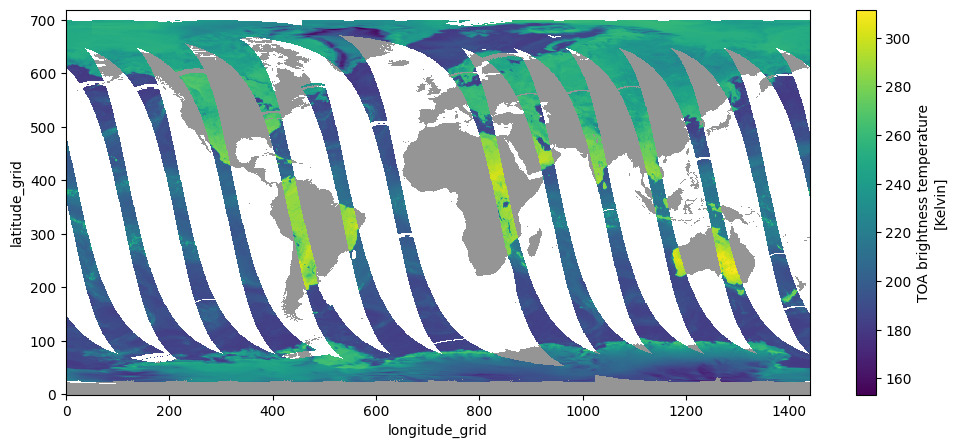

In [7]:
# Plot with the mask behind
data = ds.sel(swath_sector = 0, frequency_band = 0, polarization = 0)

fig, ax = plt.subplots(1,1, figsize = (12,5))
ds.mask.plot(ax=ax, add_colorbar=False, cmap = "Grays")
data.tbtoa.plot(ax =ax)

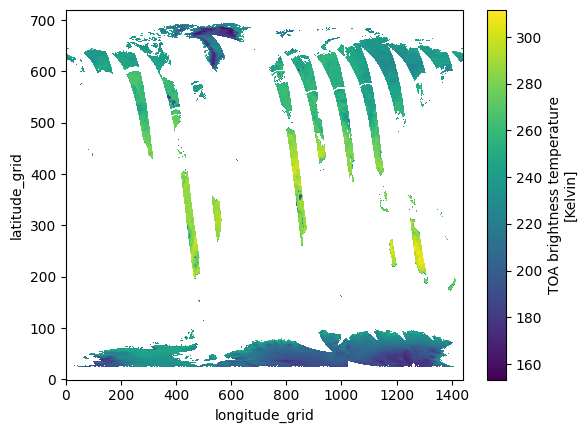

In [8]:
# Select only values where the mask exists: 
land_ds = ds.where(ds.mask == 0)
land_ds.tbtoa.sel(swath_sector = 0, frequency_band = 0, polarization =0).plot()

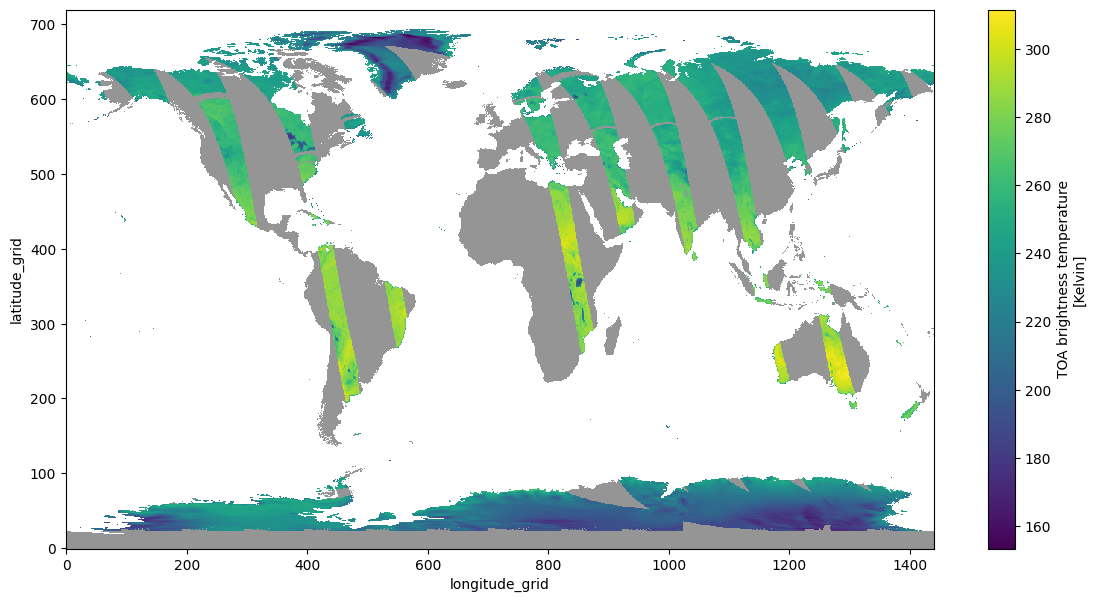

In [9]:
# Plot without the ocean:
data = land_ds.sel(swath_sector = 0, frequency_band = 0, polarization = 0)

fig, ax = plt.subplots(1,1, figsize = (14,7))
ds.mask.plot(ax=ax, add_colorbar=False, cmap = "Grays")
data.tbtoa.plot(ax =ax)


In [10]:
# load the mask once it has been created:
mask = xr.open_dataarray(save_path)
mask

<xarray.DataArray 'mask' (lat: 720, lon: 1440)> Size: 8MB
[1036800 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 180.1 180.4 180.6 180.9 ... 179.4 179.6 179.9
Attributes:
    standard_name:  region
    flag_values:    0
    flag_meanings:  lnd

--- 
--- 

# Prerpocessing step integrating all of this is now available



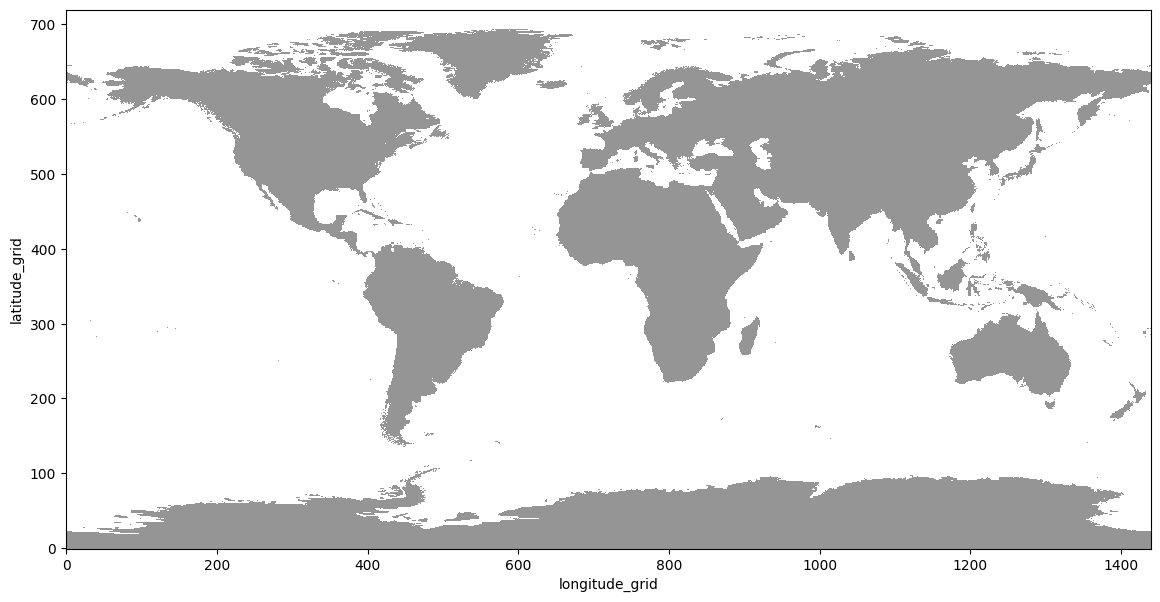

In [14]:
from src.processing import windsat_datacube, add_landmask
ds = windsat_datacube("../data/raw/daily_Windsat")
ds = add_landmask(ds)
ds.landmask.plot(add_colorbar=False, cmap = "Grays", figsize = (14,7))

In [25]:
# Global average per pixel masking the ocean:
land_ds = ds.where(ds.landmask == 0)
data = land_ds.tbtoa.mean(dim = "day_number")
data = data.sel(polarization=1, frequency_band=1,swath_sector = 1) # 37GHz, H, Descending 

fig, ax =  plt.subplots(1,1,figsize = (14,7))
ds.landmask.plot(add_colorbar=False, cmap = "Grays")
data.plot(ax=ax)

ax.set_title("TBToA for mean 37GHz (H), descending pass")